# <span style="color:lightblue"><center><b>CLASSIFICAÇÃO DOS ESTÁGIOS DA CIRROSE</b></center></span>

Neste notebook vamos realizar  um processo de classificação de Estágio da cirrose utilizando o dataset que fizemos na análise exploratória anterior ([Liver Cirrhosis Stage Classification](https://www.kaggle.com/datasets/aadarshvelu/liver-cirrhosis-stage-classification)), com a intenção de explorar e classificar a coluna **"Estágio"**, que indica qual o estágio atual da cirrose do paciente. 

Com isso, faremos a criação de modelos de Regressão Linear, Árvore de Decisão, Redes Neurais e LGBM (Modelo Ensemble) para identificar o estágio atual da cirrose de um determinado paciente, com base nos dados de input, visando a melhor acurácia possível nos modelos.

Para isso, dividimos o nosso proceder em duas seções:

**1. Importação, Transformação e Exploração**
* Aqui realizamos a importação das bibliotecas que iremos utilizar neste notebook, tratamos alguns dados e exploramos algumas correlações.

**2. Desenvolvendo Modelos**
* Já aqui, temos o desenvolvimento dos modelos de fato. Separamos em algumas subseções, uma para cada modelo que foi implementado, que no caso foram:
    * Regressão Logística
    * Árvore de Decisão
    * Rede Neural
    * LGBM


---
# **Seção 01: Importação, Transformação e Exploração**
---

### Importando as Bibliotecas


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from matplotlib.colors import LinearSegmentedColormap 
from seaborn import heatmap 
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import lightgbm as lgb
from joblib import load
from joblib import dump

In [2]:
warnings.filterwarnings('ignore') # Remoção de avisos apenas para fins estéticos do Notebook

### Importando os Dados


* Para treinar os modelos, importaremos o arquivo csv "liver_cirrhosis_v2", que foi o arquivo previamente separado na etapa de limpeza de dados, removendo boa parte das variáveis do Dataframe e deixando apenas as mais importantes para a classificação dos estágios da cirrose.

In [3]:
df = pd.read_csv('../data/dados_processados/liver_cirrhosis_v2.csv')

df['Estágio'] = pd.factorize(df['Estágio'])[0]
df.head()

,Idade,Sexo,Ascite,Hepatomegalia,Telangiectasia,Edema,Bilirrubina(mg/dl),Colesterol(mg/dl),Albumina(gm/dl),Cobre_Urina(ug/dia),Fosfatase_Alcalina (U/L),Aspartato_Aminotransferase(U/L),Triglicerídeos(mg/dl),Plaquetas(ml/1000),Tempo_de_Protrombina(s),Estágio
0,18499,F,N,S,N,N,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,0
1,19724,M,S,N,S,N,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,1
2,11839,F,N,N,N,N,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,1
3,16467,F,N,N,N,N,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,1
4,21699,F,N,S,N,N,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,0


* Agora vamos exibir apenas os dados categóricos do Dataframe importado, ignorando a coluna "Estágio", que é o nosso alvo.

In [4]:
categoric_columns = list(df.select_dtypes(include=['object']).columns)

df[categoric_columns].head()

,Sexo,Ascite,Hepatomegalia,Telangiectasia,Edema
0,F,N,S,N,N
1,M,S,N,S,N
2,F,N,N,N,N
3,F,N,N,N,N
4,F,N,S,N,N



### Transformando os Dados de Categóricos para Numéricos


* Sabemos que modelos de Machine Learning não se dão bem com dados categóricos em formato de string, que é o caso do nosso dataset. Por isso vamos usar o método "pd.factorize( )" do pandas, que é usado para codificar valores de uma série ou coluna em números inteiros, transformando as classes de strings para int. Isso permitirá usarmos os dados no modelos de regressão logística;

* Após essa transformação, iremos substituir esses valores no dataframe.

In [5]:
colunas_binarias = {column:pd.factorize(df[column])[0] for column in df[categoric_columns].columns}
df[categoric_columns] = pd.DataFrame(colunas_binarias)
df[categoric_columns].head()

,Sexo,Ascite,Hepatomegalia,Telangiectasia,Edema
0,0,0,0,0,0
1,1,1,1,1,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,0,0,0


* Como na coluna "Sexo" o valor M (Masculino) tornou-se 1, iremos mudar o nome da coluna 'Sexo' para 'Sexo Masculino', onde 1 indicará o Sexo Masculino, e 0 indicará o Sexo Feminino;

* Faremos isso pois, apenas recebendo o nome de coluna "Sexo", tendo valores binários de 0 e 1, fica confuso saber se o 0 e o 1 refere-se ao sexo masculino ou feminino. Realizando a mudança, temos a certeza de que sempre irá se referir ao sexo masculino.

In [6]:
df.rename(
    columns={'Sexo':'Sexo Masculino'}, # Mudando 'Sexo' para 'Sexo Masculino', 
    inplace=True # Realiza a mudança no prórprio df
)

# Atualizando a lista de colunas categóricas
categoric_columns.remove('Sexo')
categoric_columns.insert(0,'Sexo Masculino')

df[categoric_columns].head()

,Sexo Masculino,Ascite,Hepatomegalia,Telangiectasia,Edema
0,0,0,0,0,0
1,1,1,1,1,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,0,0,0


### Transformando a Idade de Dias para Anos


* Isso é pra uma questão mais prática, pois lidar com idade em anos é muito mais usual do que em dias. Além disso, percebermos uma certa clareza no heatmap quando estávamos comparando com a idade em dias.

In [7]:
df['Idade'] = (df['Idade']/365).astype(int)
df.head()

,Idade,Sexo Masculino,Ascite,Hepatomegalia,Telangiectasia,Edema,Bilirrubina(mg/dl),Colesterol(mg/dl),Albumina(gm/dl),Cobre_Urina(ug/dia),Fosfatase_Alcalina (U/L),Aspartato_Aminotransferase(U/L),Triglicerídeos(mg/dl),Plaquetas(ml/1000),Tempo_de_Protrombina(s),Estágio
0,50,0,0,0,0,0,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,0
1,54,1,1,1,1,0,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,1
2,32,0,0,1,0,0,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,1
3,45,0,0,1,0,0,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,1
4,59,0,0,0,0,0,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,0


### Plotando o Mapa de Calor para Analisarmos as Correlações



* Antes de prosseguir para qualquer desenvolvimento de qualquer modelo, iremos analisar as correlações das variáveis numéricas com os dados previamente separados por meio dos mapas de calor;

* Como mapas de calor usam matrizes de correlação e uma matriz de correlação é simétrica em torno do diagonal, usaremos uma máscara booleana para visualizar apenas a metade superior de uma matriz de correlação, evitando redundância.

In [8]:
# Gerar uma máscara para a metade superior e criar um mapa triangular
half_mask = np.triu(np.ones_like(df.corr(), dtype=bool))

<Axes: >

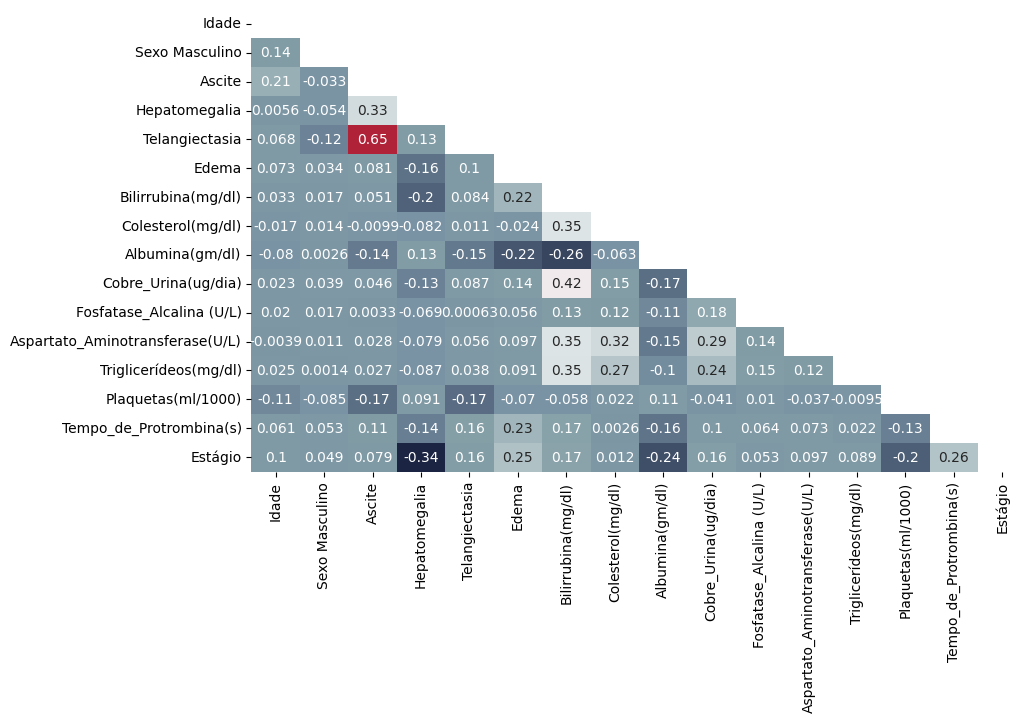

In [9]:
# Mapa de calor com as correlações
colors = ["#1b2442","#7992a4","#829da5","#f4f7f7","#b02238"]
cmap = LinearSegmentedColormap.from_list("custom_palette", colors, N=256)
plt.figure(figsize=[10,6])
heatmap(df.corr(),
        mask=half_mask, 
        annot=True, # Escreve os valores dos coeficientes
        cmap=cmap, # Paleta de cores
        cbar=False,
)

* Uma análise de correlação com heatmap é importante porque permite identificar padrões de relação entre variáveis, ajudando a entender quais características estão mais associadas umas às outras, o que pode orientar na seleção de variáveis para modelos preditivos e na compreensão da estrutura dos dados.

### Filtando os Indices de Correlação que Possui Módulo > 0.10

In [10]:
mask = df.corr().abs() >+ 0.1
filtered = df.corr().where(mask)
filtered

,Idade,Sexo Masculino,Ascite,Hepatomegalia,Telangiectasia,Edema,Bilirrubina(mg/dl),Colesterol(mg/dl),Albumina(gm/dl),Cobre_Urina(ug/dia),Fosfatase_Alcalina (U/L),Aspartato_Aminotransferase(U/L),Triglicerídeos(mg/dl),Plaquetas(ml/1000),Tempo_de_Protrombina(s),Estágio
Idade,1.000000,0.138954,0.205923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.112695,NaN,NaN
Sexo Masculino,0.138954,1.000000,NaN,NaN,-0.124024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ascite,0.205923,NaN,1.000000,0.329621,0.649646,NaN,NaN,NaN,-0.143593,NaN,NaN,NaN,NaN,-0.169384,0.114120,NaN
Hepatomegalia,NaN,NaN,0.329621,1.000000,0.132154,-0.161125,-0.196951,NaN,0.134408,-0.125755,NaN,NaN,NaN,NaN,-0.135294,-0.336901
Telangiectasia,NaN,-0.124024,0.649646,0.132154,1.000000,0.100366,NaN,NaN,-0.146398,NaN,NaN,NaN,NaN,-0.171288,0.163029,0.155757
Edema,NaN,NaN,NaN,-0.161125,0.100366,1.000000,0.224647,NaN,-0.224724,0.139269,NaN,NaN,NaN,NaN,0.225660,0.254994
Bilirrubina(mg/dl),NaN,NaN,NaN,-0.196951,NaN,0.224647,1.000000,0.352127,-0.261299,0.415027,0.132425,0.352460,0.348504,NaN,0.170697,0.172219
Colesterol(mg/dl),NaN,NaN,NaN,NaN,NaN,NaN,0.352127,1.000000,NaN,0.145983,0.117626,0.322665,0.267340,NaN,NaN,NaN
Albumina(gm/dl),NaN,NaN,-0.143593,0.134408,-0.146398,-0.224724,-0.261299,NaN,1.000000,-0.168683,-0.112587,-0.147348,-0.103031,0.107514,-0.156307,-0.237199
Cobre_Urina(ug/dia),NaN,NaN,NaN,-0.125755,NaN,0.139269,0.415027,0.145983,-0.168683,1.000000,0.184010,0.285076,0.239766,NaN,0.101950,0.160070


<Axes: >

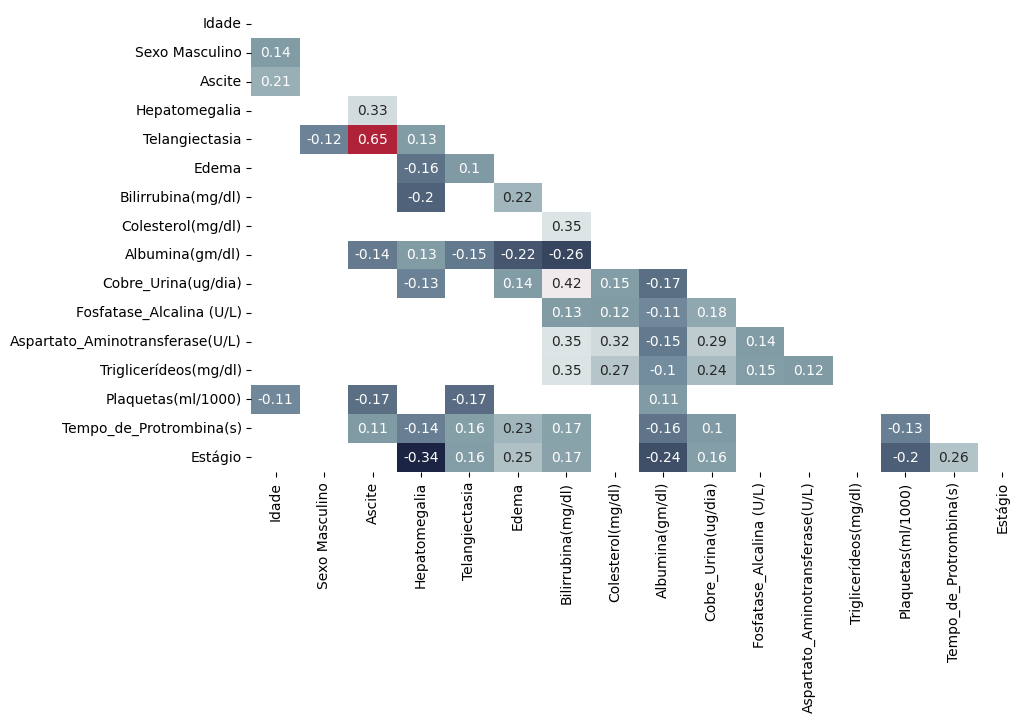

In [11]:
# Mapa de calor com as correlações cujo módulo >= 10
plt.figure(figsize=[10,6])
heatmap(
    filtered,
    mask=half_mask, 
    annot=True, # Escreve os valores dos coeficientes
    cmap=cmap, # Paleta de cores
    cbar=False
)

Perceba que Telangiectasia apresentou uma correlação positiva moderada quase forte com Ascite. Isso pode ser explicado pois: 

'Em geral, pacientes com hepatopatia e ascite apresentam outros estigmas de doença hepática, como presença de telangiectasias[...]'

> Disponível em: [Ascite no paciente cirrótico](https://www.medicinanet.com.br/conteudos/revisoes/5464/ascite_no_paciente_cirrotico.htm)

---
# **Seção 2: Desenvolvendo o Modelos**
---

## **Seção 2.1: Seperando e Normalizando os Dados**



### Separação de Dados de Treino e Teste


* Agora que os dados foram devidamente transformados e explorados, vamos separar nossa base de dados em conjuntos de treino e teste. Para isso, utilizamos o método `train_test_split` do scikit-learn;

* A princípio, iremos separar os dados entre as variáveis **preditoras** _(variáveis utilizadas para prever algo: X)_, e a variável **alvo** _(variável a ser prevista: Y)_. Nesse caso, vamos dividir 80% dos dados para treino e 20% para teste;

* Note que o dataset utilizado possui 9637 linhas no total, logo ficarão 7709 linhas para treino e 1928 para testes.

In [12]:
# Obtendo as variáveis x e y para treinar o modelo 
X = df.drop(columns=['Estágio']).values
Y = df['Estágio'].values 

# Dividindo 80% dos dados para treinar o modelo e 20% para os testes
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
print("Tamanho separado para treinos: " + str(len(X_train)))
print("Tamanho separado para testes: " + str(len(X_test)) + "\n")

print(X)
print(Y)

Tamanho separado para treinos: 7709
Tamanho separado para testes: 1928

[[ 50.    0.    0.  ...  57.  256.    9.9]
 [ 54.    1.    1.  ...  75.  220.   10.8]
 [ 32.    0.    0.  ...  80.  225.   10. ]
 ...
 [ 67.    0.    0.  ...  84.  412.   11.8]
 [ 58.    0.    0.  ...  90.  228.   10.3]
 [ 78.    1.    1.  ...  99.   97.   11.2]]
[0 1 1 ... 2 1 2]


### Normalizando os Dados

* Continuando no nosso notebook, nesta etapa iremos realizar a normalização dos dados. A normalização é um passo importante no pré-processamento dos dados para muitos algoritmos de machine learning. O objetivo da normalização é fazer com que dados de diferentes características que podem estar em diferentes escalas tenham uma escala comum;
 
* Isso é importante pois, sem normalização, características com valores maiores podem dominar aquelas com valores menores, afetando negativamente o desempenho do modelo;

* Para isso, utilizamos o objeto `StandardScaler` do scikit-learn para normalizar nossos dados de treino e teste;

* Depois de ser aplicada a normalização, salvamos o scaler na pasta _**"scalers/scaler_estagio"**_ com nome _**"estagio_scaler.joblib"**_, caso queira ser usado em alguma aplicação no futuro.

In [13]:
# Normalizando as variáveis preditoras
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test) 

# Salvando o scaler para uso futuro
print("O normalizador 'estagio_scaler' foi salvo em:")
dump(scaler, 'scalers/scalers_estagio/estagio_scaler.joblib')

O normalizador 'estagio_scaler' foi salvo em:


['scalers/scalers_estagio/estagio_scaler.joblib']

## **Seção 2.2: Modelo de Regressão Logística**

* Nosso primeiro modelo de classificação será implementado utilizando a Regressão Logística. Usaremos o objeto **Logistic Regression** e aplicaremos o método *fit()* para treinar nosso modelo. Após o treinamento, as previsões serão armazenadas em uma variável distinta. Os resultados da regressão serão exibidos em uma tabela, mostrando a precisão para cada classe e a acurácia geral, além de uma matriz de confusão para as três classes;

* Finalmente, o modelo de Regressão Logística será salvo na pasta _**"modelos/modelos_estagio"**_, no arquivo nomeado _**"estagio_logreg.joblib"**_, facilitando o acesso futuro caso necessário.

In [14]:
# Instanciando o classificador
reg_classifier = LogisticRegression(max_iter=4000, n_jobs=-1)

# Treinando o modelo
reg_classifier.fit(X_train_scaled, y_train) # Treinando o modelo

# Realizando as predições
reg_test_predict = reg_classifier.predict(X_test_scaled) # Classe da predição

# Resultados do modelo
print(classification_report(y_test, reg_test_predict))

              precision    recall  f1-score   support

           0       0.47      0.53      0.50       609
           1       0.50      0.37      0.43       669
           2       0.63      0.73      0.68       650

    accuracy                           0.54      1928
   macro avg       0.53      0.54      0.53      1928
weighted avg       0.53      0.54      0.53      1928



* O nosso modelo atingiu apenas 54% de acurácia. Outros parâmetros foram testados, além da substituição e remoção de outras variáveis, mas devido a complexidade do problema e a configuração dos dados, o modelo de Regressão Logística não é robusto o suficente. 

In [15]:
# Importância das classes para o modelo
coefficients_reg = reg_classifier.coef_
feature_importance_reg = pd.DataFrame(
    coefficients_reg.T, 
    index=df.drop('Estágio', axis=1).columns, 
    columns=reg_classifier.classes_
    )
print("Importância das Variáveis (Coeficientes):\n")
print(feature_importance_reg)

Importância das Variáveis (Coeficientes):

                                        0         1         2
Idade                           -0.009659 -0.109275  0.118933
Sexo Masculino                  -0.037523  0.048621 -0.011098
Ascite                           0.010178 -0.161918  0.151740
Hepatomegalia                    0.464771  0.041281 -0.506052
Telangiectasia                  -0.189217  0.064828  0.124389
Edema                           -0.189829  0.003522  0.186307
Bilirrubina(mg/dl)               0.027210 -0.025678 -0.001532
Colesterol(mg/dl)                0.017054  0.111335 -0.128390
Albumina(gm/dl)                  0.084762  0.179730 -0.264492
Cobre_Urina(ug/dia)             -0.116814  0.030977  0.085837
Fosfatase_Alcalina (U/L)         0.018249 -0.002196 -0.016054
Aspartato_Aminotransferase(U/L) -0.061856  0.059933  0.001922
Triglicerídeos(mg/dl)           -0.094468  0.023796  0.070672
Plaquetas(ml/1000)               0.180203 -0.014918 -0.165285
Tempo_de_Protrombina(s)    

* Interpretar os coeficientes de um modelo de regressão logística é fundamental para entender o impacto que cada variável possui na probabilidade do evento alvo. Por exemplo, um coeficiente positivo indica que quanto maior ele for, maior será a probabilidade do evento acontecer. Caso seja negativo, indica o contrário.

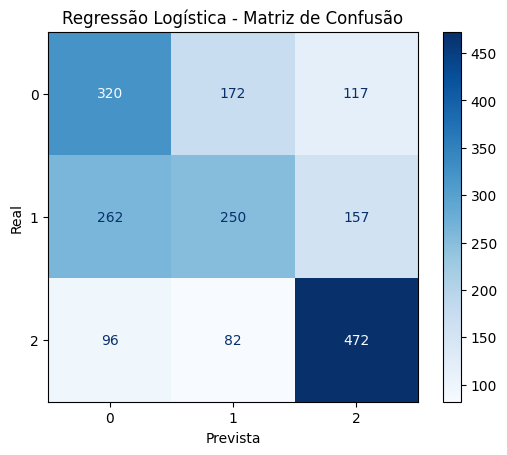

In [16]:
# Matriz de confusão
cm = confusion_matrix(y_test, reg_test_predict)

# Visualizar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=reg_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.title('Regressão Logística - Matriz de Confusão')
plt.xlabel('Prevista')
plt.ylabel('Real')

plt.show()

In [17]:
# Salvando o modelo de regressão para uso futuro
print("O modelo do scaler foi salvo em:")
dump(reg_classifier, 'models/modelos_estagio/estagio_logreg.joblib')

O modelo do scaler foi salvo em:


['models/modelos_estagio/estagio_logreg.joblib']

## **Seção 2.3: Modelo de Árvore de Decisão**


* Agora vamos explorar outra abordagem de classificação. Desta vez, utilizaremos o modelo 'Árvore de Decisão', que pode ser útil para visualizar melhor o processo de classificação e potencialmente oferecer resultados superiores em termos de acurácia e precisão. Observe que podemos reutilizar as mesmas variáveis X e Y, pois elas não foram modificadas.

* Após isso, o modelo de Árvore de Decisão será salvo na pasta _**"modelos/modelos_estagio"**_, no arquivo nomeado _**"estagio_dectree.joblib"**_, facilitando o acesso futuro caso necessário.

In [18]:
# Instanciando Árvore de Decisão
arvore = DecisionTreeClassifier(
    random_state=42, 
    min_impurity_decrease=9.1e-05,
    )

# Treinando o modelo
arvore.fit(X_train_scaled, y_train)

# Realizando as predições
arvore_predict = arvore.predict(X_test_scaled)

* O parâmetro min_impurity_decrease em uma árvore de decisão é um critério de parada que controla a criação de nós adicionais na árvore de decisão. Ele é usado para regular a complexidade da árvore, evitando o overfitting ao limitar a profundidade e o número de nós da árvore. O valor passado foi encontrado com a análise da acurácia com base no aumento ou diminuição do parâmetro.

In [19]:
# Resultados do modelo
print(classification_report(y_test,arvore_predict))

              precision    recall  f1-score   support

           0       0.74      0.77      0.76       609
           1       0.75      0.72      0.74       669
           2       0.82      0.83      0.83       650

    accuracy                           0.77      1928
   macro avg       0.77      0.77      0.77      1928
weighted avg       0.77      0.77      0.77      1928



* Perceba que o nosso modelo de Árvore de Decisão já desenvolveu uma acurácia bem melhor do que o de Regressão Logística, apresentando 77% de acurácia.

* Vamos plotar a nossa árvore de decisão, para que possamos visualizar as etapas que o modelo tomou e nós que realizou para alcançar tais resultados.

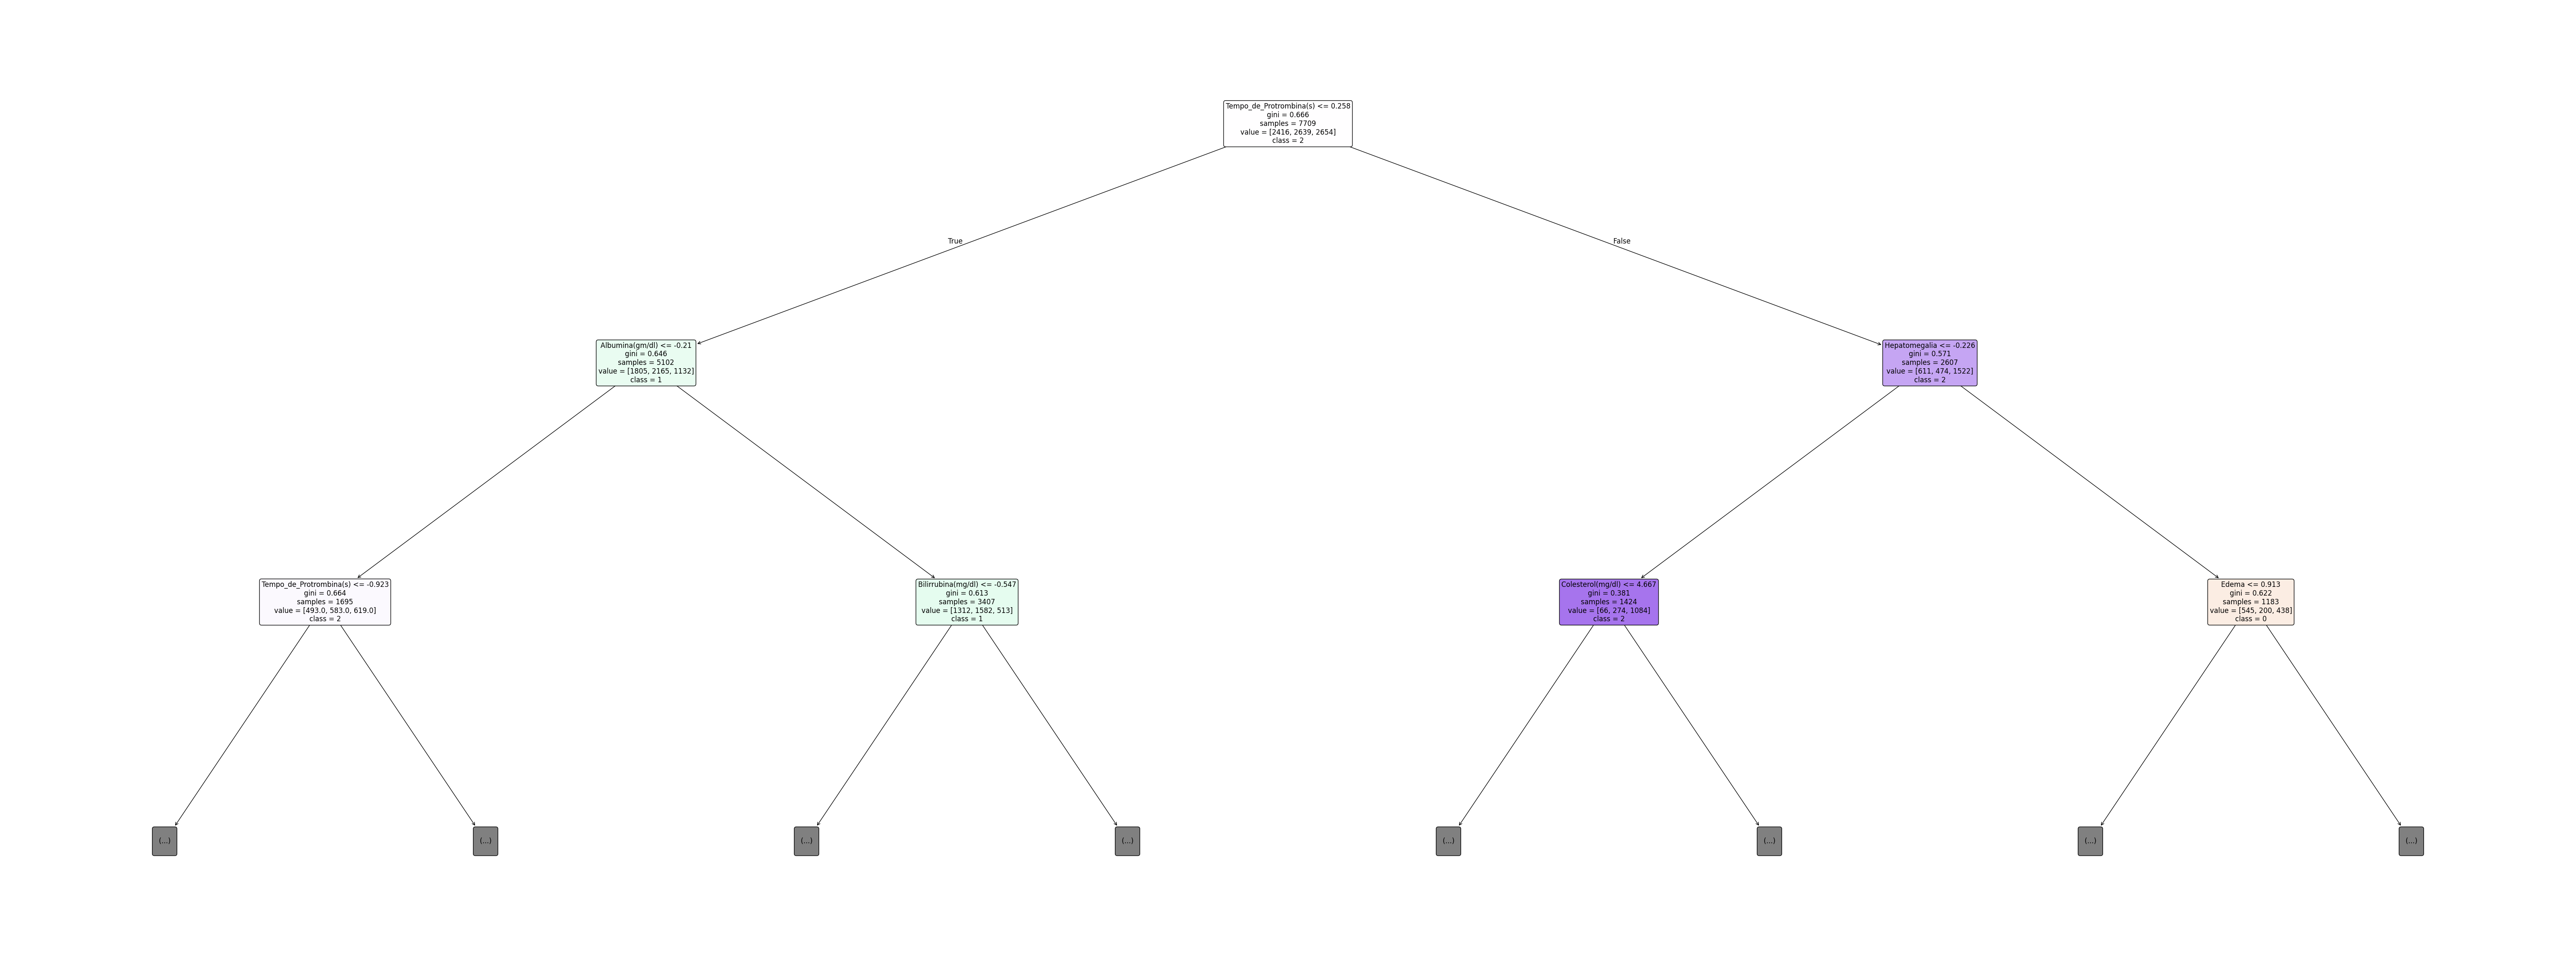

In [20]:
# Plotando a árvore
plt.figure(figsize=(80,30))
plot_tree(
    arvore, 
    feature_names=df.drop(columns=['Estágio']).columns, 
    class_names=[str(cls) for cls in arvore.classes_], 
    filled=True, 
    rounded=True, 
    fontsize=12,
    max_depth=2
    )
plt.show()

* Agora vamos realizar um teste que consiste na predição dos dados de treino, para checar uma possibilidade de _overfitting_.

In [21]:
# Realizando as predições com os dados de treino para checar possibilidade de overfitting
arvore_predict_train = arvore.predict(X_train_scaled)

# Resultados dos dados de treino
print(classification_report(y_train, arvore_predict_train))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2416
           1       0.97      0.97      0.97      2639
           2       0.98      0.98      0.98      2654

    accuracy                           0.97      7709
   macro avg       0.97      0.97      0.97      7709
weighted avg       0.97      0.97      0.97      7709



* Perceba que o modelo apresentou quase 100% de acurácia com os dados de treino, o que pode ser um indicativo de _overfitting_;

* Para evitar isso, vamos realizar uma técnica chamada Grid Search para encontrar o melhor valor para o **ccp_alpha**, um parâmetro que nos ajuda a regularizar a árvore e evitar _overfitting_.

### Realizando o Grid Search


In [22]:
# Instanciando nova árvore
arvore_teste = DecisionTreeClassifier()

# Criando o caminho da poda de complexidade de custo
path = arvore_teste.cost_complexity_pruning_path(X_train_scaled, y_train)

# Realizando o Grid Search
param_grid = {'ccp_alpha': path.ccp_alphas}

CV_clf = GridSearchCV(
    estimator=arvore, 
    param_grid=param_grid, 
    cv = 7, 
    verbose=2, 
    n_jobs=-1
    )
CV_clf.fit(X_train, y_train)

Fitting 7 folds for each of 931 candidates, totalling 6517 fits


GridSearchCV(cv=7,
             estimator=DecisionTreeClassifier(min_impurity_decrease=9.1e-05,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'ccp_alpha': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.98667990e-05, 2.16197518e-05, 2.16197518e-05, 2.16197518e-05,
       2.16197518e-05, 2.16197518e-05, 2.16197518e-05, 2.31640198e-05,
       2.52230438e-05, 2.60237753e-05, 2...
       2.56832778e-03, 2.62975314e-03, 2.79555704e-03, 2.82106876e-03,
       2.89601723e-03, 2.90475807e-03, 3.00526927e-03, 3.03808208e-03,
       3.11106202e-03, 3.13070223e-03, 3.20548642e-03, 3.26621370e-03,
       3.37321464e-03, 3.55273106e-03, 4.05480584e-03, 4.48300874e-03,
       5.75736363e-03, 7.30300602e-03, 8.47447562e-03, 1.01947498e-02,
       1.29971373e-02, 2.72504572e-02, 4.56753199e-02])},
             verbose=2)

* Com o valor em mãos, agora vamos criar outra árvore de decisão com os parâmetros modificados, com o objetivo de verificar se há uma diferença na qualidade do modelo.

In [23]:
# Atribuindo o ccp_alpha
ccp_alpha = CV_clf.best_estimator_.ccp_alpha

# Instanciando uma nova árvore com o ccp_alpha
arvore_2 = DecisionTreeClassifier(
    random_state=42, 
    ccp_alpha=ccp_alpha,
    min_impurity_decrease=9.1e-05,
)

# Ajustando o modelo DecisionTreeClassifier com os dados de treino
arvore_2.fit(X_train_scaled, y_train)

# Realizando as novas predições
arvore_2_predict = arvore_2.predict(X_test_scaled)

# Resultados do novo modelo
print(classification_report(y_test, arvore_2_predict))


              precision    recall  f1-score   support

           0       0.75      0.77      0.76       609
           1       0.75      0.73      0.74       669
           2       0.81      0.81      0.81       650

    accuracy                           0.77      1928
   macro avg       0.77      0.77      0.77      1928
weighted avg       0.77      0.77      0.77      1928



* Note que não houve mudança significativa nos resultados da acurácia do novo modelo.

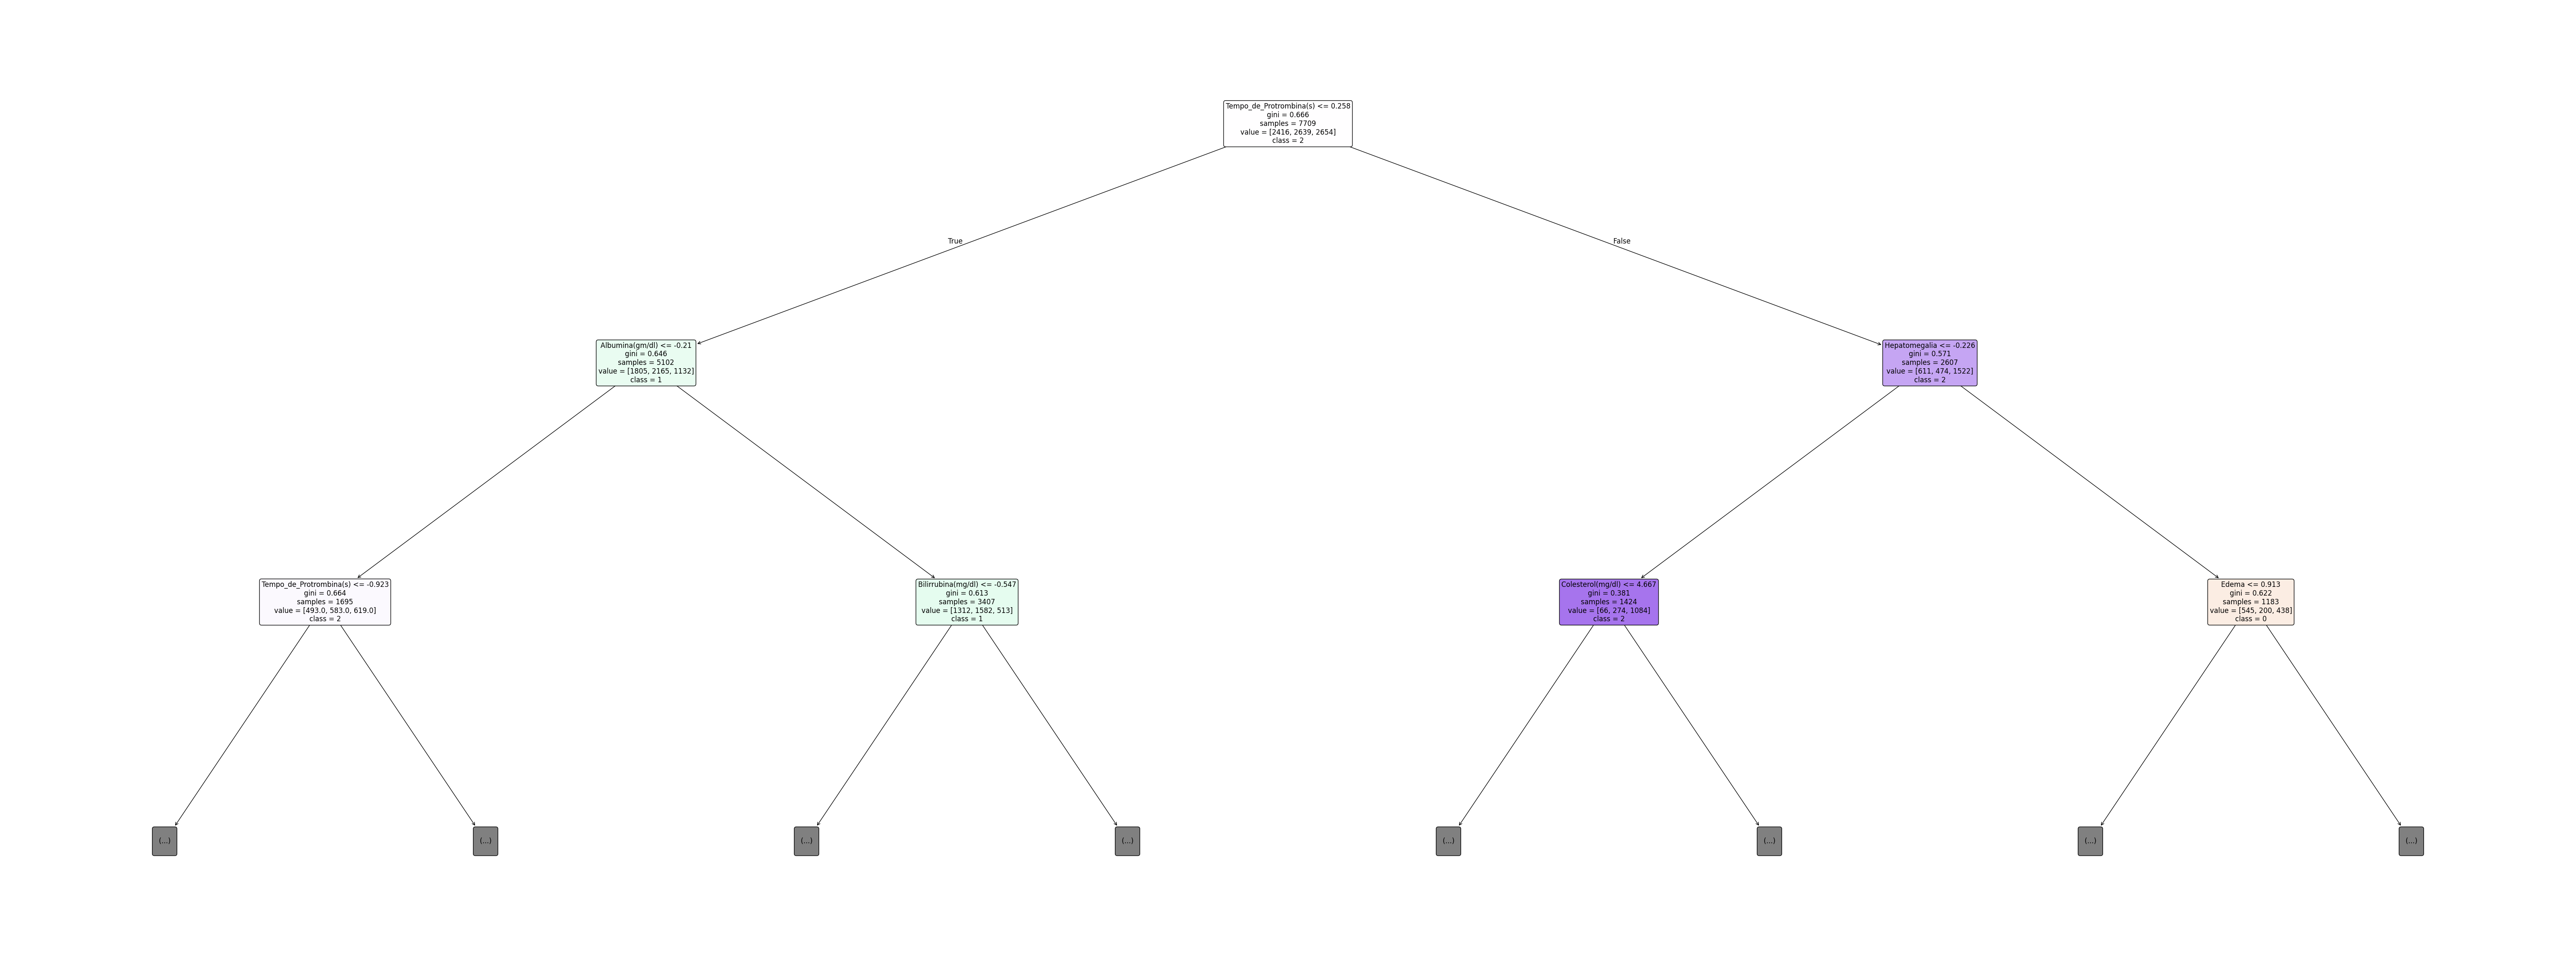

In [24]:
# Plotando a nova árvore
plt.figure(figsize=(80,30))
plot_tree(
    arvore_2, 
    feature_names=df.drop(columns=['Estágio']).columns, 
    class_names=[str(cls) for cls in arvore_2.classes_], 
    filled=True, 
    rounded=True, 
    fontsize=12,
    max_depth=2
    )
plt.show()

* Agora, vamos realizar o mesmo procedimento feito com o primeiro modelo, que consiste em realizar as predições com os dados de treino, e comparar com os resultados anteriores ao Grid Search.

In [25]:
# Fazendo as comparações
arvore_2_predict_train = arvore_2.predict(X_train_scaled)

# Resultados dos dados de treino
print(classification_report(y_train, arvore_2_predict_train))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      2416
           1       0.87      0.89      0.88      2639
           2       0.92      0.92      0.92      2654

    accuracy                           0.89      7709
   macro avg       0.89      0.89      0.89      7709
weighted avg       0.89      0.89      0.89      7709



* Opa! Perceba que a acurácia com os dados de treino caiu para 89%, porém a acurácia com os dados de teste permaneceu a mesma. Isso indica que o nosso modelo reduziu o fator de _overfitting_ sem prejudicar a acurácia com dados de teste.

In [26]:
# Obter a importância das variáveis
importances = arvore_2.feature_importances_
feature_importance_tree = pd.DataFrame(
    importances, 
    index=df.drop('Estágio', axis=1).columns, 
    columns=['Importance']
    ).sort_values(by='Importance', ascending=False)

print("Importância das Variáveis:\n")
print(feature_importance_tree)

Importância das Variáveis:

                                 Importance
Tempo_de_Protrombina(s)            0.205833
Albumina(gm/dl)                    0.176804
Plaquetas(ml/1000)                 0.144813
Hepatomegalia                      0.087253
Idade                              0.078663
Bilirrubina(mg/dl)                 0.068347
Cobre_Urina(ug/dia)                0.046128
Aspartato_Aminotransferase(U/L)    0.042780
Edema                              0.035620
Fosfatase_Alcalina (U/L)           0.033128
Triglicerídeos(mg/dl)              0.026029
Colesterol(mg/dl)                  0.022866
Telangiectasia                     0.018886
Ascite                             0.011008
Sexo Masculino                     0.001843


* As variáveis estão ordenadas em ordem decrescente com base no quanto que ela influencia o resultado de uma predição. As primeiras são as que mais influenciam e as últimas são as que não apresentam tanta influência, em termos de proporção.

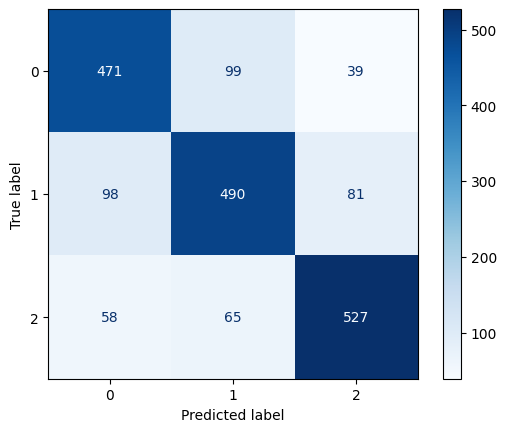

In [27]:
# Matriz de confusão
cm_tree = confusion_matrix(y_test, arvore_2_predict)

# Visualizar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tree,display_labels=arvore_2.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

* Para finalizar, vamos salvar arquivos dos nossos modelos de árvore de decisão para que possamos usá-las em outra situação.

In [28]:
print("O modelo de Árvore de Decisão foi salvo em:")
dump(arvore, 'models/modelos_estagio/estagio_dectree.joblib')

O modelo de Árvore de Decisão foi salvo em:


['models/modelos_estagio/estagio_dectree.joblib']

In [29]:
tree_clf = load('models/modelos_estagio/estagio_dectree.joblib')

In [30]:
def extract_rules(sample_id, clf):
    x_sample = X_test_scaled[sample_id]

    #Id das features analisadas em cada nó da árvore de decisão
    feature = clf.tree_.feature

    #Limiar de decisão de cada nó da árvore
    threshold = clf.tree_.threshold

    #Acessa o caminho de nós da árvore até a folha de predicao da amostra
    node_indices = clf.decision_path([x_sample]).indices 
   
    #Último nó do caminho é a folha de predição
    leaf_id = node_indices[-1]
   
    print('\nFeatures usadas para predizer a amostra %s' % (sample_id))

    for f, v in zip(df.drop(columns=['Estágio']).columns, x_sample):
        print('%s = %s'%(f,v))
    print('\n')      

    for node_id in node_indices:
        if leaf_id == node_id:
            break

        if (x_sample[feature[node_id]] <= threshold[node_id]):
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print("id do nó de decisão %s : (atributo %s com valor = %s %s %s)"
              % (node_id,
                 df.drop(columns=['Estágio']).columns[feature[node_id]],
                 x_sample[feature[node_id]],
                 threshold_sign,
                 threshold[node_id]))
        
    pred = clf.predict([x_sample])

    print("\tClasse => %s" %pred)


extract_rules(10, tree_clf)


Features usadas para predizer a amostra 10
Idade = 1.0749320892630747
Sexo Masculino = -0.35272733014080143
Ascite = -0.718143059147346
Hepatomegalia = -1.2514971061324243
Telangiectasia = -0.9697150842262937
Edema = -0.44096831220689603
Bilirrubina(mg/dl) = -0.5361848361803512
Colesterol(mg/dl) = -0.013971259681600377
Albumina(gm/dl) = 0.8457772959300359
Cobre_Urina(ug/dia) = -0.5349773562193928
Fosfatase_Alcalina (U/L) = -0.3995321820547898
Aspartato_Aminotransferase(U/L) = -0.5187027908181501
Triglicerídeos(mg/dl) = 0.020145899894030015
Plaquetas(ml/1000) = -0.21814422790926816
Tempo_de_Protrombina(s) = 0.3117374997336632


id do nó de decisão 0 : (atributo Tempo_de_Protrombina(s) com valor = 0.3117374997336632 > 0.258035384118557)
id do nó de decisão 1686 : (atributo Hepatomegalia com valor = -1.2514971061324243 <= -0.2262270748615265)
id do nó de decisão 1687 : (atributo Colesterol(mg/dl) com valor = -0.013971259681600377 <= 4.666590213775635)
id do nó de decisão 1688 : (atributo

In [31]:
# Salvando os modelos de árvore de decisão para uso futuro
print("O modelo de Árvore de Decisão foi salvo em:")
dump(arvore, 'models/modelos_estagio/estagio_dectree.joblib')

O modelo de Árvore de Decisão foi salvo em:


['models/modelos_estagio/estagio_dectree.joblib']

In [32]:
print("O modelo de Árvore de Decisão Corrigida foi salvo em:")
dump(arvore_2, 'models/modelos_estagio/estagio_dectree_corrigida.joblib')

O modelo de Árvore de Decisão Corrigida foi salvo em:


['models/modelos_estagio/estagio_dectree_corrigida.joblib']

## **Seção 2.3: Modelo de Rede Neural**

* Vamos inicializar uma rede neural com:
    * Camada de entrada com 128 neurônios (Função de ativação Relu)
    * 3 camadas com 64 neurônios
    * 1 camada com 32 neurônios
    * 1 camada com 16 neurônios
    * Camada de saída com 3 neurônios (Para as 3 classes)

In [33]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

In [34]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,283 (83.14 KB)

 Trainable params: 21,283 (83.14 KB)

 Non-trainable params: 0 (0.00 B)

* Aqui, temos o treinamento do modelo de fato. Vamos rodar 300 epochs de 32 amostras cada, para conseguir fazer um treino relativamente conciso e eficaz.

In [36]:
history = model.fit(X_train_scaled, y_train, epochs=300, batch_size=32, validation_data=(X_test_scaled, y_test))

Epoch 1/300
241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4386 - loss: 1.0496 - val_accuracy: 0.5519 - val_loss: 0.9091
Epoch 2/300
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5167 - loss: 0.9461 - val_accuracy: 0.5742 - val_loss: 0.8758
Epoch 3/300
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5450 - loss: 0.9167 - val_accuracy: 0.5892 - val_loss: 0.8459
Epoch 4/300
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5622 - loss: 0.9037 - val_accuracy: 0.6022 - val_loss: 0.8425
Epoch 5/300
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5922 - loss: 0.8784 - val_accuracy: 0.6068 - val_loss: 0.8278
Epoch 6/300
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5954 - loss: 0.8724 - val_accuracy: 0.6271 - val_loss: 0.8050
Epoch 7/300
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6015 - loss: 0.8569 - val_accuracy: 0.6328 - val_loss: 0.8129
Epoch 8/300
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6076 - loss: 0.8482 - val_accu

* Note que a acurácia parece se estabilizar em torno de 76%. Poderíamos prosseguir, mas a diferença não seria significativa. A seguir, gráficos que ajudam a visualizar o aumento da acurácia em nossa rede neural.

In [37]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

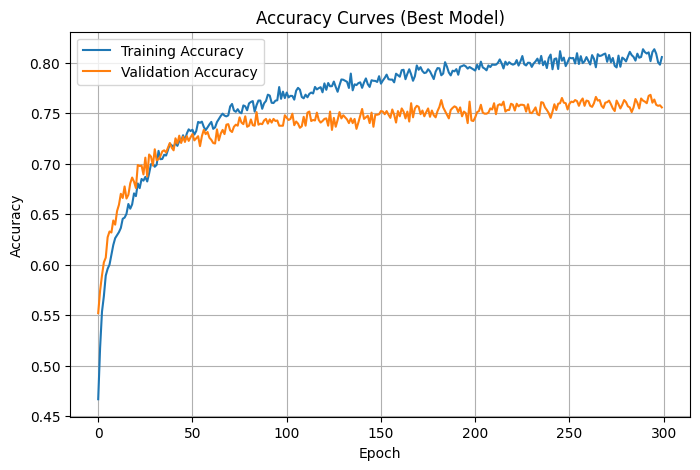

In [38]:
# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Curves (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

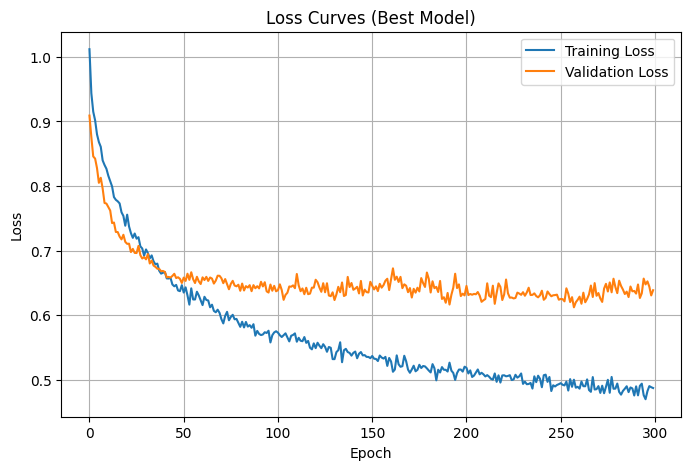

In [39]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curves (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

* Por fim, printar os reports da classificação para analisar os resultados finais do nosso modelo (e checar se está acontecendo overfitting).

In [40]:
print(classification_report(y_test, np.argmax(model.predict(X_test_scaled), axis=1)))

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       609
           1       0.71      0.72      0.72       669
           2       0.85      0.78      0.82       650

    accuracy                           0.76      1928
   macro avg       0.76      0.76      0.76      1928
weighted avg       0.76      0.76      0.76      1928



* Vamos salvar o modelo:

In [41]:
print("O modelo de Rede Neural foi salvo em:")
dump(model, 'models/modelos_estagio/estagio_naural.joblib')

O modelo de Rede Neural foi salvo em:


['models/modelos_estagio/estagio_naural.joblib']

## **Seção 2.4: Modelo de Light Gradient Boosting Machine (LGBM)**

* Para finalizar com nosso último modelo, vamos empregar agora a classificação utilizando o Light Gradient Boosting Machine (ou LGBM). Este modelo, ao contrário dos demais, emprega um processo de ensemble (basicamente utilizando diversos algoritmos distintos de machine learning) para tornar o modelo mais eficiente e prático.

In [42]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label= y_test)

parameters = {
'objective': 'multiclass',
'boosting_type': 'gbdt',
'metric': 'multi_logloss',
'num_class': len(np.unique(y_test)),
'num_leaves': 31,
'learning_rate': 0.05,
'feature_fraction': 0.9
}

model_lgbm = lgb.train(parameters, train_data, valid_sets=[train_data, valid_data], num_boost_round=5000)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1538
[LightGBM] [Info] Number of data points in the train set: 7709, number of used features: 15
[LightGBM] [Info] Start training from score -1.160275
[LightGBM] [Info] Start training from score -1.071988
[LightGBM] [Info] Start training from score -1.066321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [43]:
# Faz previsões
y_train_pred = model_lgbm.predict(X_train)
y_valid_pred = model_lgbm.predict(X_test)

# Converte as previsões para rótulos de classe
y_train_pred_labels = np.argmax(y_train_pred, axis=1)
y_valid_pred_labels = np.argmax(y_valid_pred, axis=1)

* Depois de treinar o modelo, vamos checar as tabelas para tomar conclusões.


In [44]:
# Tabela de resultado com os dados de treino
print("Report - Dados de Treino:")
print(classification_report(y_train, y_train_pred_labels, zero_division=0))

Report - Dados de Treino:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2416
           1       0.98      0.99      0.99      2639
           2       1.00      1.00      1.00      2654

    accuracy                           0.99      7709
   macro avg       0.99      0.99      0.99      7709
weighted avg       0.99      0.99      0.99      7709



In [45]:
# Resultados com os dados de
print("Report - LGBM:")
print(classification_report(y_test, y_valid_pred_labels, zero_division=0))

Report - LGBM:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       609
           1       0.89      0.89      0.89       669
           2       0.94      0.93      0.94       650

    accuracy                           0.90      1928
   macro avg       0.90      0.90      0.90      1928
weighted avg       0.90      0.90      0.90      1928



[[545  48  16]
 [ 52 593  24]
 [ 18  26 606]]


<Figure size 600x600 with 0 Axes>

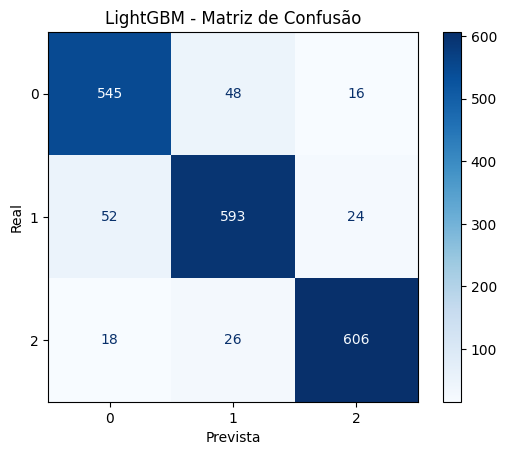

In [46]:
# Matriz de Confusão
matrixLGBMT = confusion_matrix(y_test, y_valid_pred_labels)
print(matrixLGBMT)

plt.figure(figsize=(6, 6))
matrixLGBMPlot1 = ConfusionMatrixDisplay(confusion_matrix=matrixLGBMT, display_labels=np.unique(y_test))
matrixLGBMPlot1.plot(cmap=plt.cm.Blues)

plt.title('LightGBM - Matriz de Confusão')
plt.xlabel('Prevista')
plt.ylabel('Real')

plt.show()

In [47]:
# Salvando o modelo
print("O modelo de LightGBM foi salvo em:")
dump(model_lgbm, 'models/modelos_estagio/estagio_lightgbm.joblib')

O modelo de LightGBM foi salvo em:


['models/modelos_estagio/estagio_lightgbm.joblib']